/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_patch16_224_dino to current vit_base_patch16_224.dino.
  model = create_fn(


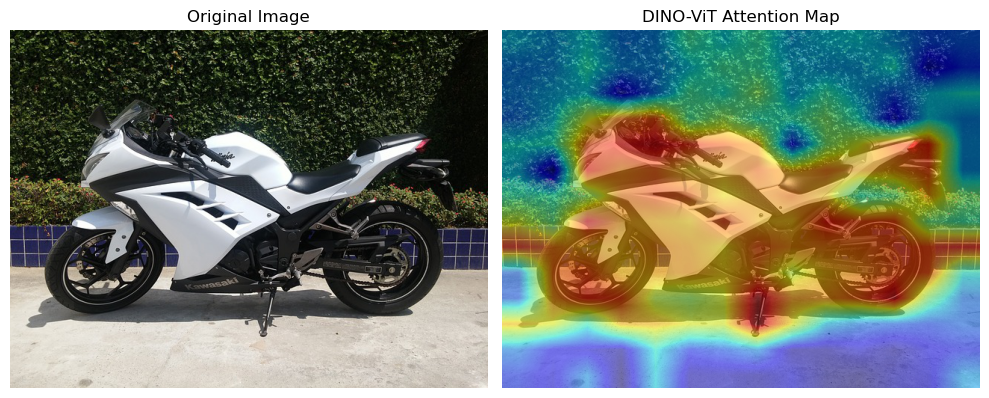

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import timm
import torchvision.transforms as T

# USE DINO-ViT MODEL (pretrained)
model = timm.create_model('vit_base_patch16_224_dino', pretrained=True)
model.eval()

# Load image 
image_path =  "/home/DATA/AGD20K/Seen/testset/egocentric/sit_on/motorcycle/motorcycle_000837.jpg"
image = Image.open(image_path).convert('RGB')  

# Image preprocess
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = transform(image).unsqueeze(0)

# Model output with attention weights
with torch.no_grad():
    # Get features including attention
    outputs = model.forward_features(img_tensor)  # Shape: (batch_size, 197, feature_dim)
    
    # Extract patch tokens (CLS 제외)
    patch_tokens = outputs[:, 1:, :]  # (batch_size, 196, feature_dim)
    
    # Attention map: 패치 토큰의 노름(norm)을 사용해 중요도 계산
    attn_map = torch.norm(patch_tokens, dim=-1).reshape(14, 14)  # (14x14)
    
    # 정규화 (0~1 범위로 스케일링)
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

# Attention Map 전체 시각화
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original image
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Attention Map
attn_map_resized = np.array(Image.fromarray(attn_map.numpy()).resize(image.size, resample=Image.Resampling.BILINEAR))
ax[1].imshow(image)
ax[1].imshow(attn_map_resized, cmap='jet', alpha=0.5)  # Attention Map > heat map
ax[1].axis('off')
ax[1].set_title('DINO-ViT Attention Map')

plt.tight_layout()
plt.show()